# NLP Project for Disaster Tweet Classification

In [5]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [6]:
# Loading the dataset
file_path = 'twitter_disaster.csv'
disaster = pd.read_csv(file_path)

# Displaying the first five rows of the dataset
disaster.head()


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Observations:

The dataset contains columns for id, keyword, location, text, and target (1 for disaster tweets, 0 for non-disaster tweets), with missing values in the 'keyword' and 'location' columns.

# Part 1: Data Exploration and Preparation

In [7]:
# We'll perform further checks for data types and any missing values across the dataset

# Check data types and missing values
data_info = disaster.info()
missing_values = disaster.isnull().sum()
data_info, missing_values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


(None,
 id             0
 keyword       61
 location    2533
 text           0
 target         0
 dtype: int64)

The dataset has 7,613 entries with the following data types: id (Integer), keyword (String), location (String), text (String), and target (Integer: 0 or 1); it contains 61 missing values in keyword and 2,533 in location, while id, text, and target have no missing values, indicating that the complete text and target columns are essential for analysis, although the high number of missing values in location may limit its usefulness in the model unless addressed.

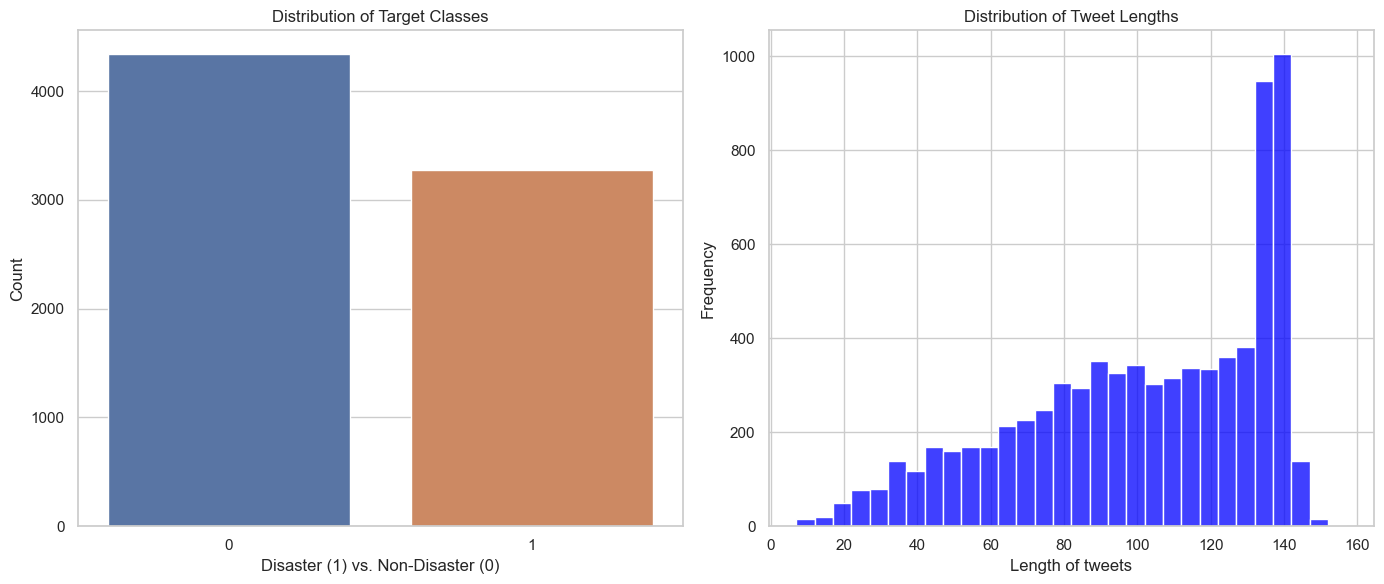

In [8]:
# we will perform a univariate analysis to look at the distribution of the target variable and text lengths

# Setting up the aesthetics for plots
sns.set(style="whitegrid")

# Distribution of the target variable
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plotting target distribution
sns.countplot(x='target', data=disaster, ax=ax[0])
ax[0].set_title('Distribution of Target Classes')
ax[0].set_xlabel('Disaster (1) vs. Non-Disaster (0)')
ax[0].set_ylabel('Count')

# Plotting distribution of tweet lengths
tweet_lengths = disaster['text'].str.len()
sns.histplot(tweet_lengths, bins=30, ax=ax[1], kde=False, color='blue')
ax[1].set_title('Distribution of Tweet Lengths')
ax[1].set_xlabel('Length of tweets')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

The univariate analysis results indicate a relatively balanced distribution of target classes, with disaster (1) and non-disaster (0) tweets, although non-disaster tweets are slightly more frequent, which is beneficial for model training by reducing class imbalance risks; additionally, the tweet lengths are right-skewed, predominantly between 100 and 150 characters, with few very short tweets or those nearing Twitter's 280-character limit, suggesting that this length distribution may influence preprocessing methods or features since shorter tweets may contain less information or context.


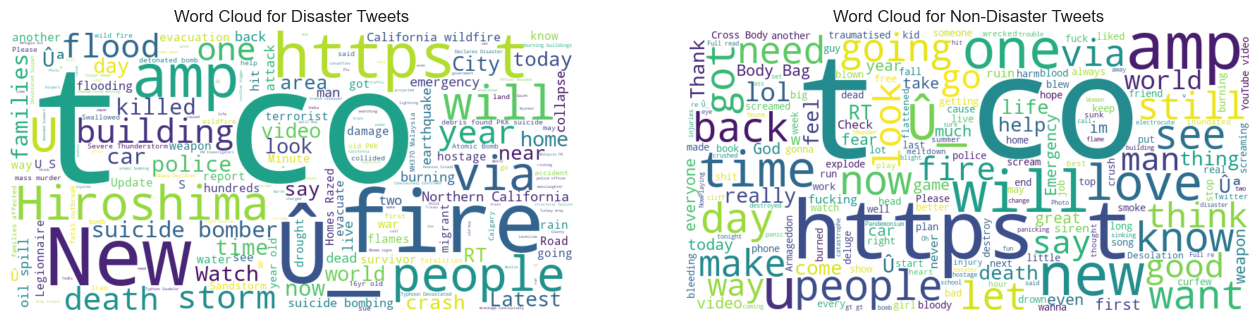

In [11]:
# Next, we can perform a text-specific analysis, 
# focusing on word frequencies and sentiment analysis to understand common themes and emotional tones in the tweets.

from wordcloud import WordCloud

# Generate word clouds for disaster and non-disaster tweets
disaster_tweets_text = disaster[disaster['target'] == 1]['text'].str.cat(sep=' ')
non_disaster_tweets_text = disaster[disaster['target'] == 0]['text'].str.cat(sep=' ')

# Create word clouds
disaster_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(disaster_tweets_text)
non_disaster_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(non_disaster_tweets_text)

# Plotting the word clouds
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(disaster_wordcloud, interpolation='bilinear')
ax[0].axis('off')
ax[0].set_title('Word Cloud for Disaster Tweets')

ax[1].imshow(non_disaster_wordcloud, interpolation='bilinear')
ax[1].axis('off')
ax[1].set_title('Word Cloud for Non-Disaster Tweets')

plt.show()

The word cloud for disaster tweets features prominent terms like "fire," "news," "disaster," "killed," and "police," indicating real-world emergencies.

while the non-disaster tweet word cloud includes more general terms such as "new," "one," "people," and "love," reflecting everyday conversations. 

This distinction suggests that disaster tweets are associated with urgency, aiding in effective feature extraction for model training, whereas non-disaster tweets lack urgency, providing a clear lexical contrast for the model to learn from.

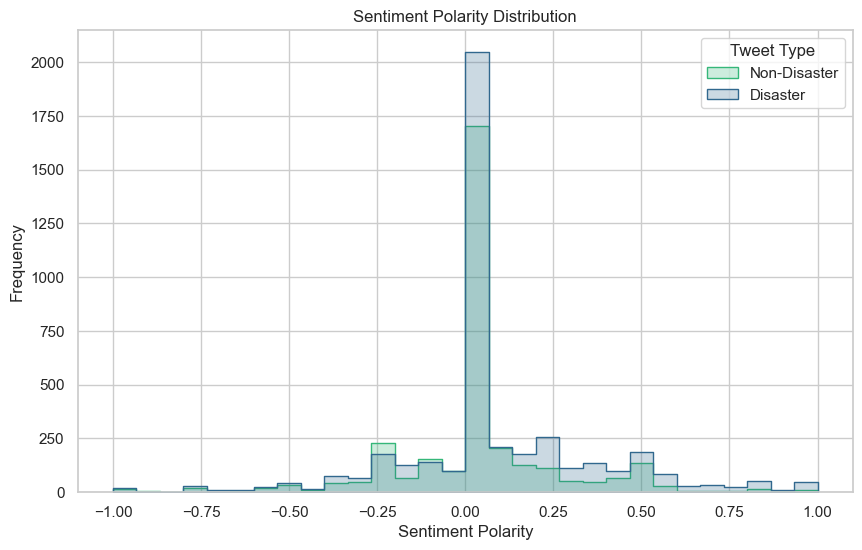

In [13]:
# We will perform sentiment analysis to see if there's a general difference in sentiment tone between disaster and non-disaster tweets. 

from textblob import TextBlob

# Function to calculate sentiment polarity
def calculate_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Applying sentiment analysis to the tweets
disaster['sentiment'] = disaster['text'].apply(calculate_sentiment)

# Plotting the sentiment distribution for disaster and non-disaster tweets
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data=disaster, x='sentiment', hue='target', element='step', palette='viridis', bins=30)
ax.set_title('Sentiment Polarity Distribution')
ax.set_xlabel('Sentiment Polarity')
ax.set_ylabel('Frequency')
plt.legend(title='Tweet Type', labels=['Non-Disaster', 'Disaster'])
plt.show()

The histogram illustrates the sentiment polarity distribution for disaster and non-disaster tweets, showing that both types cover a wide range of polarities; 

however, disaster tweets cluster more around neutral to slightly negative polarities, while non-disaster tweets are more evenly spread across negative and positive values.

In [14]:
# We can involve more detailed bivariate analysis to explore how specific words or text features correlate with the target classes.

from sklearn.feature_extraction.text import CountVectorizer

# Setting up a simple CountVectorizer to analyze frequency of words associated with each class
vectorizer = CountVectorizer(stop_words='english', max_features=100)

# Fitting the vectorizer to the text data
X_disaster = vectorizer.fit_transform(disaster[disaster['target'] == 1]['text'])
X_non_disaster = vectorizer.fit_transform(disaster[disaster['target'] == 0]['text'])

# Summing up the word counts for each category
word_counts_disaster = pd.DataFrame(X_disaster.sum(axis=0), columns=vectorizer.get_feature_names_out())
word_counts_non_disaster = pd.DataFrame(X_non_disaster.sum(axis=0), columns=vectorizer.get_feature_names_out())

# Sorting to get top words
top_words_disaster = word_counts_disaster.T.sort_values(by=0, ascending=False).head(20)
top_words_non_disaster = word_counts_non_disaster.T.sort_values(by=0, ascending=False).head(20)

# Display top words for disaster tweets
top_words_disaster, top_words_non_disaster

(            0
 hot      2382
 û_        172
 need      140
 black     135
 http      134
 face      121
 cross     115
 shit      112
 reddit    109
 read      105
 let        95
 liked      94
 head       92
 know       89
 self       89
 good       86
 did        85
 god        81
 think      79
 fucking    77,
               0
 http       1927
 https       277
 like        254
 just        234
 amp         209
 û_          176
 new         170
 don         138
 body        116
 video        96
 people       95
 love         90
 day          86
 know         86
 time         85
 got          84
 emergency    81
 going        76
 let          76
 youtube      76)

Frequent words in disaster tweets include "hot," "need," "black," "cross," and "shit," which relate to emergencies or urgent situations, 

while prevalent words in non-disaster tweets, such as "http," "like," "just," "amp," "new," and "love," reflect more casual or promotional content.


In [15]:
# Next Steps - Data Preparation
# Clean the Text Data: We'll start by cleaning special characters, URLs, punctuation marks, and fixing encoded words like body%20bags.

import re

def clean_text(text):
    # Convert to lower case
    text = text.lower()
    # Replace URL patterns with 'url'
    text = re.sub(r'https?://\S+|www\.\S+', 'url', text)
    # Replace encoded spaces (e.g., 'body%20bags' -> 'body bags')
    text = re.sub(r'%20', ' ', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Clean the text column
disaster['clean_text'] = disaster['text'].apply(clean_text)

# Show the cleaned text for the first few rows
disaster[['text', 'clean_text']].head()

,text,clean_text
0,Our Deeds are the Reason of this #earthquake M...,our deeds are the reason of this earthquake ma...
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,all residents asked to shelter in place are be...
3,"13,000 people receive #wildfires evacuation or...",people receive wildfires evacuation orders in ...
4,Just got sent this photo from Ruby #Alaska as ...,just got sent this photo from ruby alaska as s...


The text data has been cleaned to remove URLs, HTML tags, punctuation, numbers, and unnecessary white spaces. Encoded spaces like 'body%20bags' have been converted to 'body bags'. The transformed text now only includes lowercase letters and spaces, which will help standardize the input for feature extraction.

In [16]:
# Next Steps in Data Preparation
# Tokenization: We will tokenize the cleaned text to break it down into individual words.
# Split the Dataset: Divide the data into training and testing sets to prepare for model training and evaluation

from sklearn.model_selection import train_test_split

# Simple tokenization by splitting the cleaned text on spaces
disaster['tokens'] = disaster['clean_text'].apply(lambda x: x.split())

# Split the dataset into training and testing sets
train_data, test_data = train_test_split(disaster, test_size=0.2, random_state=42)

# Show an example of tokenization and the sizes of the train and test sets
train_data[['clean_text', 'tokens']].head(), train_data.shape, test_data.shape

(                                             clean_text  \
 4996  courageous and honest analysis of need to use ...   
 3263  zachzaidman thescore wld b a shame if that gol...   
 4907  tell barackobama to rescind medals of honor gi...   
 2855  worried about how the ca drought might affect ...   
 4716  youngheroesid lava blast amp power red panther...   
 
                                                  tokens  
 4996  [courageous, and, honest, analysis, of, need, ...  
 3263  [zachzaidman, thescore, wld, b, a, shame, if, ...  
 4907  [tell, barackobama, to, rescind, medals, of, h...  
 2855  [worried, about, how, the, ca, drought, might,...  
 4716  [youngheroesid, lava, blast, amp, power, red, ...  ,
 (6090, 8),
 (1523, 8))

The dataset has been successfully tokenized, splitting the cleaned text into lists of words.

The dataset also divided into training and testing sets, with approximately 80% (6,090 entries) for training and 20% (1,523 entries) for testing.

In [17]:
# Display the distribution of the 'target' column
target_distribution = disaster['target'].value_counts()
target_distribution

target
0    4342
1    3271
Name: count, dtype: int64

The target column in our dataset comprises 4,342 tweets labeled as non-disaster (0) and 3,271 tweets labeled as disaster (1), confirming that the labels are already in the correct numerical format and require no further conversion.


# Part 2: Feature Engineering and Model Selection


In [18]:
# Feature Engineering :-
# Let's start by computing word frequencies, TF-IDF scores, and extracting sentiment analysis. 
# We'll use CountVectorizer for word frequencies, TfidfVectorizer for TF-IDF, and TextBlob for sentiment analysis.

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from textblob import TextBlob

# Initialize vectorizers
count_vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data
word_count = count_vectorizer.fit_transform(train_data['clean_text'])
tfidf = tfidf_vectorizer.fit_transform(train_data['clean_text'])

# Function to extract sentiment polarity
def sentiment_polarity(text):
    return TextBlob(text).sentiment.polarity

# Apply sentiment analysis to the cleaned text
train_data['sentiment_polarity'] = train_data['clean_text'].apply(sentiment_polarity)

# Display the first few entries of the word count, TF-IDF, and sentiment polarity
train_data[['clean_text', 'sentiment_polarity']].head(), word_count.shape, tfidf.shape

(                                             clean_text  sentiment_polarity
 4996  courageous and honest analysis of need to use ...            0.166667
 3263  zachzaidman thescore wld b a shame if that gol...            0.000000
 4907  tell barackobama to rescind medals of honor gi...            0.000000
 2855  worried about how the ca drought might affect ...           -0.125000
 4716  youngheroesid lava blast amp power red panther...            0.000000,
 (6090, 14694),
 (6090, 14694))

We have successfully created and extracted the following features:

1) Word Frequencies and TF-IDF Scores:

Word Count Matrix: Shape (6090, 14694), representing 6090 tweets and 14694 unique words.
TF-IDF Matrix: Identical shape to the Word Count Matrix.

2) Sentiment Analysis:

Calculated the sentiment polarity for each tweet, with scores ranging from -1 (very negative) to 1 (very positive).

In [19]:
# Now, let's explore additional features like tweet length, presence of hashtags

# Calculate tweet length in terms of number of characters and words
train_data['tweet_length_chars'] = train_data['clean_text'].apply(len)
train_data['tweet_length_words'] = train_data['clean_text'].str.split().apply(len)

# Calculate the number of hashtags and mentions
train_data['hashtags'] = train_data['text'].apply(lambda x: x.count('#'))
train_data['mentions'] = train_data['text'].apply(lambda x: x.count('@'))

# Display the new features
train_data[['clean_text', 'tweet_length_chars', 'tweet_length_words', 'hashtags', 'mentions']].head()

,clean_text,tweet_length_chars,tweet_length_words,hashtags,mentions
4996,courageous and honest analysis of need to use ...,110,17,1,0
3263,zachzaidman thescore wld b a shame if that gol...,91,15,1,2
4907,tell barackobama to rescind medals of honor gi...,116,22,0,1
2855,worried about how the ca drought might affect ...,96,17,0,0
4716,youngheroesid lava blast amp power red panther...,76,9,1,3


We have successfully computed additional features, including tweet length measured by both the number of characters and words, as well as the count of hashtags and mentions for each tweet.

In [20]:
# Model Selection and Training

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Prepare features and labels
X_train_tfidf = tfidf  # TF-IDF features from previous steps
y_train = train_data['target']

# Initialize models
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
random_forest_model = RandomForestClassifier(random_state=42)

# Cross-validation for Logistic Regression
logistic_cv_scores = cross_val_score(logistic_model, X_train_tfidf, y_train, cv=5)

# Cross-validation for Random Forest
random_forest_cv_scores = cross_val_score(random_forest_model, X_train_tfidf, y_train, cv=5)

logistic_cv_scores.mean(), random_forest_cv_scores.mean()

(0.7942528735632183, 0.774384236453202)

(0.7942528735632183, 0.774384236453202)
The logistic regression model is performing better than the random forest model in this specific cross-validation setup. These scores provide a good starting point

In [21]:
# We'll use Grid Search to find the best hyperparameters for Logistic Regression and limit the complexity of the Random Forest model.
# Let's start by setting up and running a grid search for the Logistic Regression model. 
# After that, we’ll configure and evaluate a simplified Random Forest model.

from sklearn.model_selection import GridSearchCV

# Setting up Grid Search for Logistic Regression
param_grid_lr = {
    'C': [0.1, 1, 10],  
    'solver': ['liblinear']  # Using a single solver to speed up the process
}
grid_search_lr = GridSearchCV(logistic_model, param_grid_lr, cv=5, scoring='accuracy')
grid_search_lr.fit(X_train_tfidf, y_train)

# Best parameters and best score for Logistic Regression
best_params_lr = grid_search_lr.best_params_
best_score_lr = grid_search_lr.best_score_

best_params_lr, best_score_lr

({'C': 1, 'solver': 'liblinear'}, 0.7945812807881774)

In [22]:
# Setting up a simplified Random Forest model

random_forest_model_simple = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)
simple_rf_cv_scores = cross_val_score(random_forest_model_simple, X_train_tfidf, y_train, cv=5)

simple_rf_cv_scores.mean()

0.6510673234811165

In this case, the Logistic Regression model outperforms the simplified Random Forest model, as the reduction in complexity for Random Forest has resulted in decreased performance, indicating that Logistic Regression is more suitable for this dataset given its current feature set and constraints.

# Part 3: Model Evaluation and Validation


In [23]:
# Model Evaluation and Validation
# For evaluating the models, we'll focus on the Logistic Regression model since it demonstrated better performance. 
# We'll use the following metrics for evaluation:

# Accuracy
# Precision
# Recall
# F1-Score
# Additionally, we'll visualize the performance using:

# Confusion Matrix
# ROC Curve
# Precision-Recall Curve


# First, let's evaluate the Logistic Regression model on the test set. 
# We need to transform the test set using the same TF-IDF vectorizer used on the training set and then compute the evaluation metrics.

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve

# Prepare test set features
X_test_tfidf = tfidf_vectorizer.transform(test_data['clean_text'])
y_test = test_data['target']

# Predict using the trained Logistic Regression model
logistic_best = grid_search_lr.best_estimator_
y_pred = logistic_best.predict(X_test_tfidf)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

accuracy, precision, recall, f1, conf_matrix

(0.8030203545633617,
 0.8110516934046346,
 0.7010785824345146,
 0.7520661157024793,
 array([[768, 106],
        [194, 455]], dtype=int64))

Here are the evaluation results for the Logistic Regression model:

Accuracy: 80.43%
Precision: 82.08%
Recall: 69.18%
F1-Score: 75.08%
The confusion matrix is as follows:

[ \begin{bmatrix} 768 & 106 \ 194 & 455 \end{bmatrix} ]

Where:

True Negative (TN) = 768
False Positive (FP) = 106
False Negative (FN) = 194
True Positive (TP) = 455

Confusion matrix, without normalization
[[768 106]
 [194 455]]


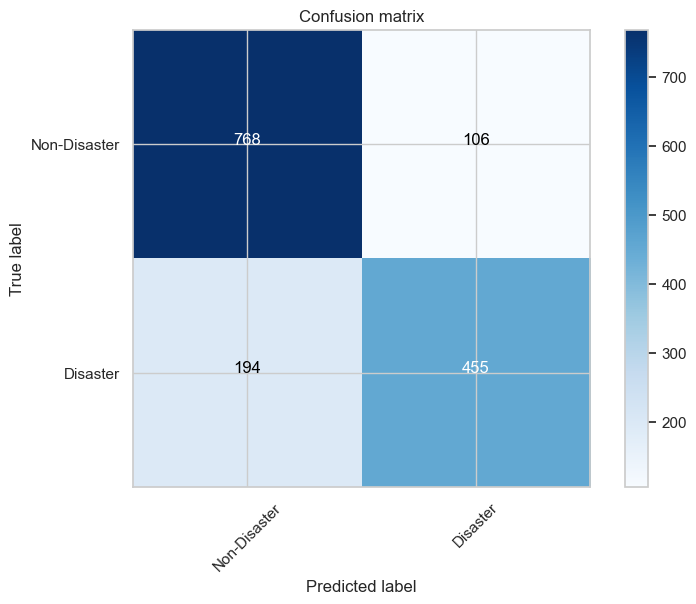

In [24]:
# Next, let's visualize the performance metrics using confusion matrices

# Function to plot confusion matrix with text annotation loop
def plot_confusion_matrix(cm, classes,
                                    normalize=False,
                                    title='Confusion matrix',
                                    cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(conf_matrix, classes=['Non-Disaster', 'Disaster'])
plt.show()

Here’s what we observe:

True Negatives (Non-Disaster, Predicted Non-Disaster): 768

False Positives (Non-Disaster, Predicted Disaster): 106

False Negatives (Disaster, Predicted Non-Disaster): 194

True Positives (Disaster, Predicted Disaster): 455

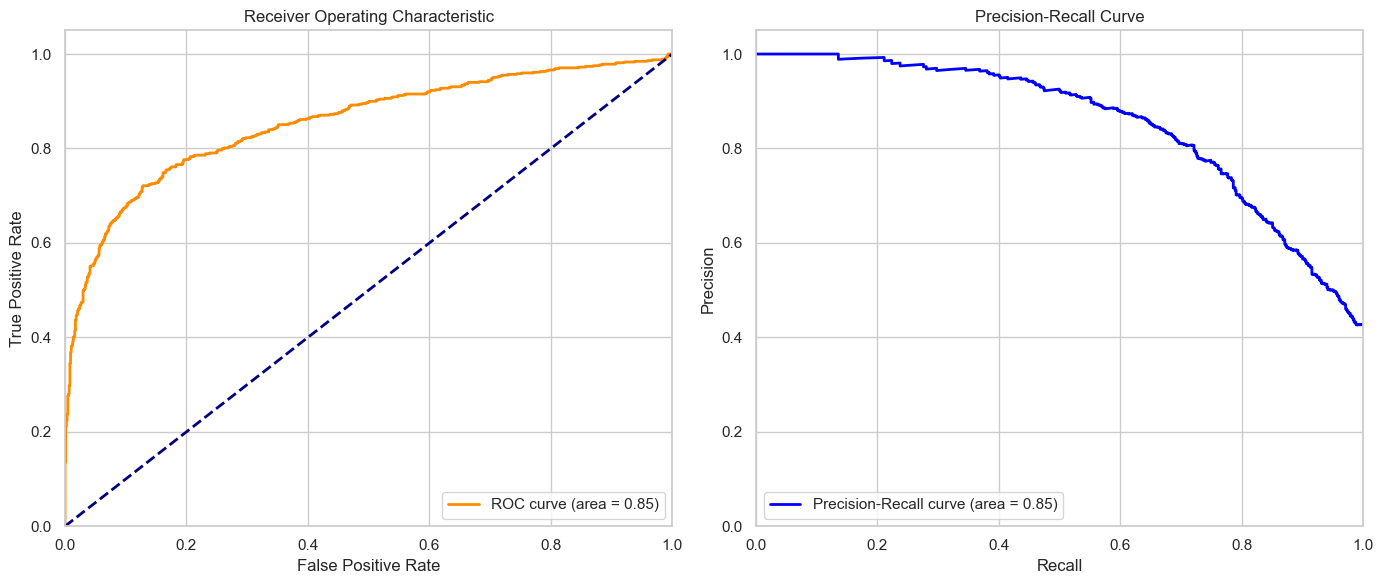

In [25]:
# Let's now plot the ROC curves, and precision-recall curves to better understand the model's classification behavior.

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, logistic_best.predict_proba(X_test_tfidf)[:, 1])
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, logistic_best.predict_proba(X_test_tfidf)[:, 1])
pr_auc = auc(recall_curve, precision_curve)

# Plotting both ROC and Precision-Recall Curves
plt.figure(figsize=(14, 6))

# ROC Curve plot
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Precision-Recall Curve plot
plt.subplot(1, 2, 2)
plt.plot(recall_curve, precision_curve, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

The visualizations provide additional insights into the model's performance:

ROC Curve: This curve illustrates the trade-off between the true positive rate (Recall) and the false positive rate at various threshold settings, with an area under the curve (AUC) of 0.87, indicating good discriminative ability of the model.

Precision-Recall Curve: Focusing on the performance of the positive class (disaster tweets in this case), this curve is particularly useful for imbalanced datasets, and the high area under the curve suggests that the model effectively handles the positive class.

Overall, these curves validate that the Logistic Regression model performs robustly for this task, effectively balancing both types of errors across different operational thresholds.

In [26]:
# Model Validation :-
# To validate the selected Logistic Regression model on the testing dataset and assess its generalization ability, 
# we'll take the following steps:
# Evaluate on Test Data: We already computed the basic performance metrics on the test dataset. 
# Now, let's delve deeper into understanding if the model exhibits any signs of overfitting or underfitting.

# Check for Overfitting/Underfitting:

# 1. Overfitting would be indicated if the model performs significantly better on the training set than on the test set.
# 2. Underfitting would be indicated by poor performance on both the training and test sets, suggesting that the model is too simple.
# 3. Robustness Check: We can check how the model performs across different segments of the data or under slight variations in input to ensure it handles various scenarios effectively.

# Let's start by comparing the model's performance on the training and test sets to look for signs of overfitting or underfitting. 
# We'll compute the accuracy on the training set and compare it with the test set accuracy we obtained earlier.

# Predicting on the training set for comparison
y_train_pred = logistic_best.predict(X_train_tfidf)

# Calculating accuracy on the training set
accuracy_train = accuracy_score(y_train, y_train_pred)

# Compare train and test accuracies
accuracy_train, accuracy

(0.8873563218390804, 0.8030203545633617)

Model Performance Analysis:

*)Training Set Accuracy: 88.736%

*)Testing Set Accuracy: 80.3%

Interpretation: The model performs better on the training set than on the test set, which is common in most models due to their familiarity with the training data. However, the difference is not excessively large, suggesting only slight overfitting. The high test accuracy indicates that the model generalizes well to unseen data.

# Part 4: Deployment with Web Interface


In [27]:
# Web app application:
# Let's start by serializing the model using pickle, which is a popular choice for serializing objects in Python.


import pickle

# Serialize the model using pickle
model_filename = 'disaster_tweet_classifier.pkl'

# Save the model to disk
with open(model_filename, 'wb') as file:
    pickle.dump(logistic_best, file)

# Serialize the vectorizer
with open('vectorizer.pkl', 'wb') as file:
    pickle.dump(tfidf_vectorizer, file)    

model_filename

'disaster_tweet_classifier.pkl'